In [2]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys
import ipywidgets as widgets
from IPython.display import display
import napari
import pandas as pd

from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from skimage.morphology import binary_dilation, disk

import json
import re

# run this jupyter notebook with the kernel base_env_apifish_w_man_reg

   For rounds in which the same gene appears, the registration is based on binary images, single rna spots are
represented as pixels with value 1. 
   As the segmentation masks around cells can vary from round to round: we create an expanded binary mask which is
the union of all the segmentation masks accross rounds. Each mask being previously expanded by a factor that compensates
the displacement due to the fluidics. With this global mask, we select the detected points in each round, and 
measure their colocalization.

In [3]:
%load_ext autoreload
%autoreload 2
    
base_dir = Path("../../pipeline/src").resolve()
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "utils"))
sys.path.append(str(base_dir / "detection_fish"))
sys.path.append(str(base_dir / "segmentation"))

from utils.parameters_tracking import Parameter_tracking as Track
from utils.file_handling import FileProcessor
from detection_fish.detect_fish_spots import DetectionPipeline
from detection_fish.thresh_big_fish_napariV3 import SpotsThresholding 
from segmentation.refine_seg import Segmentation

tk  = Track()
det = DetectionPipeline()
sg  = Segmentation()
fp  = FileProcessor()

In [4]:
def colocalization_analysis(gene1_spot: np.ndarray, gene2_spot: np.ndarray, thresh_dist=None):
    """associates together spots that are closer than a threshold.
    
    Args:
        gene1_spot (np.ndarray): positions of the first gene detected (of dimensions 2 or 3)
        gene2_spot (np.ndarray): positions of the second gene detected.
        thresh_dist (_type_, optional): Defaults to np.sqrt(2).
    
    
    Returns:
        gene1_alone_number (int): number of positions in which the gene 1 is alone.
        gene2_alone_number (int): number of positions in which the gene 2 is alone.
        gene_a_b_together_num (int):  number of positions in which both genes colocalize.
        positions_overlap  (np.ndarray): coordinates of overlapping points.
        """    
    if thresh_dist is None:
        n = len(gene1_spot[0])
        thresh_dist = np.ceil(np.sqrt(n) * 100) / 100

    dist_mat = np.zeros((len(gene1_spot), len(gene2_spot)))
    for ind_l, coord_g1 in enumerate(gene1_spot):
        for ind_c, coord_g2 in enumerate(gene2_spot):
            dist_mat[ind_l, ind_c] = euclidean_dist(coord_g1, coord_g2)

    dist_mat_thresh = dist_mat.copy()
    dist_mat_thresh[dist_mat > thresh_dist] = np.nan

    dist_mat_thresh_c = dist_mat_thresh.copy()
    gene1_spot_c = gene1_spot.copy()
    gene2_spot_c = gene2_spot.copy()

    list_gene1_only = []
    list_gene2_only = []
    list_gene1_gene2 = []

    while len(dist_mat_thresh_c):
        coord_start = gene1_spot_c[0, :]
        line_dist = dist_mat_thresh_c[0]
        ind_2 = nanargmin(line_dist)
        if isinstance(ind_2, np.ndarray):  # proxi for np.array([])
            # remove first element from list 1
            list_gene1_only.append(coord_start)
            gene1_spot_c = np.delete(gene1_spot_c, 0, axis=0)
            gene1_spot_c = np.atleast_2d(gene1_spot_c)
            dist_mat_thresh_c = np.delete(dist_mat_thresh_c, 0, axis=0)
            dist_mat_thresh_c = np.atleast_2d(dist_mat_thresh_c)
        else:
            col_dist = dist_mat_thresh_c[:, ind_2]
            ind_1 = nanargmin(col_dist)
            if isinstance(ind_1, np.ndarray):
                # retirer b
                list_gene2_only.append(gene2_spot_c[ind_2, :])
                gene2_spot_c = np.delete(gene2_spot_c, ind_2, axis=0)
                gene2_spot_c = np.atleast_2d(gene2_spot_c)
                dist_mat_thresh_c = np.delete(dist_mat_thresh_c, ind_2, axis=1)
                dist_mat_thresh_c = np.atleast_2d(dist_mat_thresh_c)
            else:
                # retirer b, a'
                list_gene1_gene2.append(
                    (gene1_spot_c[ind_1, :], gene2_spot_c[ind_2, :])
                )
                gene1_spot_c = np.delete(gene1_spot_c, ind_1, axis=0)
                gene1_spot_c = np.atleast_2d(gene1_spot_c)
                gene2_spot_c = np.delete(gene2_spot_c, ind_2, axis=0)
                gene2_spot_c = np.atleast_2d(gene2_spot_c)
                dist_mat_thresh_c = np.delete(dist_mat_thresh_c, ind_2, axis=1)
                dist_mat_thresh_c = np.atleast_2d(dist_mat_thresh_c)
                dist_mat_thresh_c = np.delete(dist_mat_thresh_c, ind_1, axis=0)
                dist_mat_thresh_c = np.atleast_2d(dist_mat_thresh_c)

    if len(gene2_spot_c):
        for coords in gene2_spot_c:
            list_gene2_only.append(coords)

    return list_gene1_only, list_gene2_only, list_gene1_gene2
    
def euclidean_dist(x: np.ndarray, y: np.ndarray):
    return np.sqrt(np.sum((x - y) ** 2))
    
def nanargmin(arr, axis=None, nan_position="last"):
    """
    Find the indices of the minimum values along an axis ignoring NaNs.
    Similar to np.nanargmin, but handles edge cases and nan_position more robustly.

    Args:
        arr (numpy.ndarray): The input array.
        axis (int, optional): The axis along which to operate. Defaults to None,
                            meaning find the minimum of the flattened array.
        nan_position (str, optional): Where to put NaNs in the sorted indices.
                                    'first': NaNs at the beginning.
                                    'last': NaNs at the end.
                                    Defaults to 'last'.

    Returns:
        numpy.ndarray: An array of indices of the minimum values.  Returns an
                    empty array if all elements are NaN or the input is empty.
                    Returns a scalar if axis is None.

    Raises:
        ValueError: If nan_position is not 'first' or 'last'.
    """

    if nan_position not in ("first", "last"):
        raise ValueError("nan_position must be 'first' or 'last'")

    arr = np.asanyarray(arr)  # handle potential non-numpy inputs

    if arr.size == 0:  # Handle empty array case
        return np.array(
            []
        )  # Return empty array, consistent with np.nanargmin behavior

    mask = np.isnan(arr)

    if np.all(mask):  # Handle all-NaN case
        if axis is None:
            return np.array([])  # Return empty array for consistency
        else:
            if nan_position == "first":
                return np.zeros(
                    arr.shape[:axis] + arr.shape[axis + 1 :], dtype=int
                )  # Return array of zeros
            else:  # nan_position == 'last'
                return np.full(
                    arr.shape[:axis] + arr.shape[axis + 1 :],
                    arr.shape[axis] - 1,
                    dtype=int,
                )  # Return array of last index values

    if axis is None:
        # Flatten and handle 1D array
        flat_arr = arr.flatten()
        flat_mask = mask.flatten()
        valid_indices = np.where(~flat_mask)[0]  # Indices of non-NaN values
        if valid_indices.size == 0:  # all NaN
            return np.array([])
        min_index_flat = valid_indices[np.argmin(flat_arr[valid_indices])]
        return min_index_flat

    else:
        # Handle multi-dimensional array and specified axis
        valid_indices = np.where(~mask)

        if valid_indices[0].size == 0:  # all NaN along the axis
            if nan_position == "first":
                return np.zeros(arr.shape[:axis] + arr.shape[axis + 1 :], dtype=int)
            else:  # nan_position == 'last'
                return np.full(
                    arr.shape[:axis] + arr.shape[axis + 1 :],
                    arr.shape[axis] - 1,
                    dtype=int,)
        min_indices = np.zeros(arr.shape[:axis] + arr.shape[axis + 1 :], dtype=int)
        for idx in np.ndindex(*arr.shape[:axis], *arr.shape[axis + 1 :]):
            sl = list(idx[:axis]) + [slice(None)] + list(idx[axis:])
            arr_slice = arr[tuple(sl)]
            mask_slice = mask[tuple(sl)]
            valid_slice_indices = np.where(~mask_slice)[
                0
            ]  # Indices of non-NaN values
            if valid_slice_indices.size > 0:
                min_index_slice = valid_slice_indices[
                    np.argmin(arr_slice[valid_slice_indices])
                ]
                min_indices[idx] = min_index_slice
        return min_indices

In [5]:
var = str(Path('../Analysis'))
batch_folders = os.listdir(var)
dropdown = widgets.Dropdown(options=batch_folders, description='Select:', layout=widgets.Layout(width='auto', min_width='150px'))
display(dropdown)

Dropdown(description='Select:', layout=Layout(min_width='150px', width='auto'), options=('kraken',), value='kr…

In [6]:
n         = np.where(np.array(batch_folders) == dropdown.value)[0][0]
file_path = str(Path(var) / Path(batch_folders[n]) / Path(batch_folders[n] +'.json'))
constants = tk.load_json(file_path)

In [7]:
meth       = 'BIGFISH'
modality   = 'KRAKEN'
chan_f     = 'FISH'
chan_c     = 'FISH'
struc      = 'CELL'

dots_path          = constants[f'DOTS_{meth}_{modality}_{chan_f}_PATH']
spots_dict         = fp.load_spots_distributed_files(dots_path, constants['SPOTS_FORMAT'])
batch_mod_fish_mip = constants[f'BATCH_{modality}_{chan_c}_{struc}_MIP']

mask_fish_area_path= constants[f'MASK_{modality}_FISH_AREA_PATH']
fish_area_dict     = fp.load_masks_distributed_files(mask_fish_area_path)

In [8]:
batch_mod_fish_mip_137 = [[f'../Analysis/kraken/KRAKEN/FISH/CELL/train_2D/2025-08-25_Kraken-Papier3_D_R1_r1_s{i:02d}_MIP_FISH_CELL.tif',
                           f'../Analysis/kraken/KRAKEN/FISH/CELL/train_2D/2025-08-25_Kraken-Papier3_D_R1_r3_s{i:02d}_MIP_FISH_CELL.tif',
                           f'../Analysis/kraken/KRAKEN/FISH/CELL/train_2D/2025-08-25_Kraken-Papier3_D_R1_r7_s{i:02d}_MIP_FISH_CELL.tif',] 
                           for i in range(0, 25)]

batch_mod_fish_mip_258 = [[f'../Analysis/kraken/KRAKEN/FISH/CELL/train_2D/2025-08-25_Kraken-Papier3_D_R1_r2_s{i:02d}_MIP_FISH_CELL.tif',
                           f'../Analysis/kraken/KRAKEN/FISH/CELL/train_2D/2025-08-25_Kraken-Papier3_D_R1_r5_s{i:02d}_MIP_FISH_CELL.tif',
                           f'../Analysis/kraken/KRAKEN/FISH/CELL/train_2D/2025-08-25_Kraken-Papier3_D_R1_r8_s{i:02d}_MIP_FISH_CELL.tif',] 
                           for i in range(0, 25)]

In [9]:
make_visualizations = True
colors    = ['red','green','blue']
dims      = np.shape(io.imread(batch_mod_fish_mip_137[0][0]))
upsample  = 1   # no upsampling

In [10]:
import napari
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from skimage.morphology import binary_dilation, disk

def align_same_gene_using_phase_crosscorrelation(batch_mod_fish_mip: list, fish_area_dict: dict, spots_dict: dict, make_visualizations: bool):

    dic_im_shifted = {}
    dic_spots_corrected = {}
    
    for batch_mod_fish_mip_temp in batch_mod_fish_mip:
        mask_pres_list     = []
        expanded_mask_list = []
        list_im_bin_spots  = []
        list_clean_spots   = []
        mask_tot           = np.zeros(dims, dtype=int) # def a binary mask : array of 1's and zeros
    
        for ind, file in enumerate(batch_mod_fish_mip_temp):   # compute total masks: union of the expanded masks
            file                  = Path(file)
            file_name             = str(file.stem)
            base_name             = '_'.join(Path(file).stem.split('_')[:-3])
            
            mask_fish             = fish_area_dict[base_name]
            mask_fish_dilated     = binary_dilation(mask_fish, footprint=disk(15))  # before: 30
            # Taking a large dilation parameter wants to compensate for the drift caused by the fluidics,
            # so that the majority of the points are conserved.
            if mask_fish.any():
                mask_pres = True
            else:
                mask_pres = False
            mask_pres_list.append(mask_pres)
            mask_tot = np.logical_or(mask_fish_dilated, mask_tot)    # grows increasily
                                                                    
        for ind, file in enumerate(batch_mod_fish_mip_temp):         # with the expanded masks, clean the spots.
            file         = Path(file)
            file_name    = str(file.stem)
            base_name    = '_'.join(Path(file).stem.split('_')[:-3])
            
            df_spots     = spots_dict[base_name]
            spots_raw_2d = df_spots[['Y', 'X']].to_numpy()
            
            im_spots = np.zeros(dims, dtype=np.uint16)               # create binary images.
            im_spots[spots_raw_2d[:,0], spots_raw_2d[:,1]] = 1      
            im_spots = im_spots*mask_tot                             # clean the spots (with the same mask)
            coords_y, coords_x = np.nonzero(im_spots)
            spots_cleaned_2d = np.column_stack((coords_y, coords_x))
    
            list_im_bin_spots.append(im_spots)                     
            list_clean_spots.append(spots_cleaned_2d)
    
        reference_image = list_im_bin_spots[0]                           # alignent : first image with second and with third.
        spots_ref       = list_clean_spots[0]
    
        list_shifted_images         = [batch_mod_fish_mip_temp[0]]    
        list_spots_corrected        = [list_clean_spots[0]]
        list_im_shifted             = [io.imread(batch_mod_fish_mip_temp[0])]
        
        
        file                        = Path(batch_mod_fish_mip_temp[0])
        file_name                   = str(file.stem)
        base_name                   = '_'.join(Path(file).stem.split('_')[:-3])
        dic_im_shifted[base_name]   = io.imread(batch_mod_fish_mip_temp[0])
        dic_spots_corrected[base_name] = list_clean_spots[0]


        for u in range(1, len(batch_mod_fish_mip_temp)):
            if mask_pres_list[u] and mask_pres_list[0]:
                file             = Path(batch_mod_fish_mip_temp[u])
                file_name        = str(file.stem)
                moving_image     = list_im_bin_spots[u]
                shift_cc, _, _   = phase_cross_correlation(reference_image, moving_image, upsample_factor=upsample)
                shift_y, shift_x = int(shift_cc[0]), int(shift_cc[1])

                if shift_y**2 + shift_x**2 > 30**2:
                    print(f' {file_name}: shift too high: {np.sqrt(shift_y**2 + shift_x**2)}')
                    shift_y = 0
                    shift_x = 0
                
                spots_corrected  = np.hstack((list_clean_spots[u][:,0].reshape((-1,1)) + shift_y,
                                              list_clean_spots[u][:,1].reshape((-1,1)) + shift_x))
                spots_corrected[:, 0]   = np.clip(spots_corrected[:, 0], 0, dims[0]-1)
                spots_corrected[:, 1]   = np.clip(spots_corrected[:, 1], 0, dims[1]-1)
                list_spots_corrected.append(spots_corrected)
                            
                im2                     = io.imread(batch_mod_fish_mip_temp[u])
                im2_shifted             = shift(im2, shift=(shift_y, shift_x), mode='constant', cval=0)
                list_im_shifted.append(im2_shifted)

                file                    = Path(batch_mod_fish_mip_temp[u])
                file_name               = str(file.stem)
                base_name               = '_'.join(Path(file).stem.split('_')[:-3])
                
                dic_im_shifted[base_name]      = im2_shifted
                dic_spots_corrected[base_name] = spots_corrected

        if make_visualizations and mask_pres_list[u] and mask_pres_list[0]:
            viewer  = napari.Viewer(title=f"FISH accross rounds, file {Path(batch_mod_fish_mip_temp[0]).stem}")
            for ind, file in enumerate(batch_mod_fish_mip_temp):
                im        = io.imread(file)
                filename  = str(Path(file).stem)
                viewer.add_image(im, contrast_limits=[0, np.percentile(im, 99)], rgb=False, name=f"FISH {filename}", opacity=0.8)
                viewer.add_points(list_clean_spots[ind], name=f"Spots  {filename}", size=4, face_color='k')
                viewer.add_image(list_im_shifted[ind], name=f"Image shifted{filename}", contrast_limits=[0, np.percentile(list_im_shifted[ind], 99)], rgb=False, opacity=0.8)
                viewer.add_points(list_spots_corrected[ind], name=f"Spots  {filename}", size=4, face_color=colors[ind])
 
    return dic_im_shifted, dic_spots_corrected

In [13]:
dic_im_shifted_137, dic_spots_corrected_137 = align_same_gene_using_phase_crosscorrelation(batch_mod_fish_mip_137, fish_area_dict, spots_dict, False)

In [14]:
dic_im_shifted_258, dic_spots_corrected_258 = align_same_gene_using_phase_crosscorrelation(batch_mod_fish_mip_258, fish_area_dict, spots_dict, False)

/tmp/ipykernel_1024868/1749162174.py:71: UserWarning: Could not determine RMS error between images with the normalized average intensities 3.0 and 0.0. Either the reference or moving image may be empty.
  shift_cc, _, _   = phase_cross_correlation(reference_image, moving_image, upsample_factor=upsample)
/tmp/ipykernel_1024868/1749162174.py:71: UserWarning: Could not determine RMS error between images with the normalized average intensities 1.0 and 0.0. Either the reference or moving image may be empty.
  shift_cc, _, _   = phase_cross_correlation(reference_image, moving_image, upsample_factor=upsample)


 2025-08-25_Kraken-Papier3_D_R1_r8_s04_MIP_FISH_CELL: shift too high: 135.20724832641184


In [15]:
matching_r1_names = []
for name in list(dic_im_shifted_137.keys()):
    if re.search(r'_r1', name):
        matching_r1_names.append(name)

matching_r2_names = []
for name in list(dic_im_shifted_258.keys()):
    if re.search(r'_r2', name):
        matching_r2_names.append(name)

In [16]:
pattern = r'(_s\d+)'

r2_map = {}
for name_r2 in matching_r2_names:
    match = re.search(pattern, name_r2)
    if match:
        identifier = match.group(1)
        r2_map[identifier] = name_r2

matching_tuples = []
for name_r1 in matching_r1_names:
    match = re.search(pattern, name_r1)
    if match:
        identifier = match.group(1)  
        if identifier in r2_map:
            tuple_r2_r1 = (r2_map[identifier], name_r1)
            matching_tuples.append(tuple_r2_r1)

In [17]:
dict_spots_aligned_to_r1 = dic_spots_corrected_137.copy()
dict_im_aligned_to_r1    = dic_im_shifted_137.copy()

In [74]:
# Open and close the napari alignment tool, iterate over the tuples:
n_tup = 12

viewer     = napari.Viewer(title=f'#{n_tup}')
im1_ref    = dic_im_shifted_137[matching_tuples[n_tup][1]]
im_to_reg  = dic_im_shifted_258[matching_tuples[n_tup][0]]

ref_layer = viewer.add_image(im1_ref, name='Reference Layer', contrast_limits=[0, np.percentile(im1_ref,99)], colormap="#aa00FF")
float_layer = viewer.add_image(im_to_reg, name='Floating Layer', contrast_limits=[0, np.percentile(im_to_reg, 99)], colormap="#aa0000")
float_layer.opacity = 0.5


try:
    widget_instance = viewer.window.add_plugin_dock_widget(
        plugin_name='napari-manual-registration',
        widget_name='register_by_sliders' # Target the 'Explicit Registration' mode
    )
except KeyError:
    widget_instance = viewer.window.add_plugin_dock_widget(
        plugin_name='napari-manual-registration'
    )


if hasattr(widget_instance, 'reference_layer'):
    widget_instance.reference_layer.value = ref_layer
if hasattr(widget_instance, 'layer_floating'):
    widget_instance.floating_layer.value = float_layer


print("Manual Registration plugin opened and layers pre-selected. Ready for GUI input.")

Manual Registration plugin opened and layers pre-selected. Ready for GUI input.


I save the shifts in the Shifts folder. In it there is a subfolder 
named 1, 2, 3 , ..., 24 in which there is a .json file called 
initial_transformation.json, from which we are going to read
the keys trans_y and trans_x, which gives the translation in pixels.

In [18]:
threshold_coloc = 2     # in pixels (threshold for considering that two rna's are colocalized). 
coloc_data = [] 

for n_tup in range(25):
    with open(f'./Shifts/{n_tup}/initial_transformation.json', 'r') as file:
        dic_trans = json.load(file)
        dy = dic_trans['trans_y']
        dx = dic_trans['trans_x']

    r2_name = matching_tuples[n_tup][0]
    if r2_name in list(dic_spots_corrected_258.keys()):
        spots_temp_r2_corr      = dic_spots_corrected_258[r2_name].copy()
        spots_temp_r2_corr[:,0] = spots_temp_r2_corr[:,0] + dy
        spots_temp_r2_corr[:,1] = spots_temp_r2_corr[:,1] + dx
        im2                     = dic_im_shifted_258[r2_name]
        im2_shifted             = shift(im2, shift=(dy, dx), mode='constant', cval=0)

    else:
        if 'spots_temp_r2_corr' in list(globals().keys()):
            del spots_temp_r2_corr
        if 'im2' in list(globals().keys()):
            del im2
    
    r5_name = re.sub(r'(r2)', r'r5', r2_name)
    if r5_name in list(dic_spots_corrected_258.keys()):
        spots_temp_r5_corr      = dic_spots_corrected_258[r5_name].copy()
        spots_temp_r5_corr[:,0] = spots_temp_r5_corr[:,0] + dy
        spots_temp_r5_corr[:,1] = spots_temp_r5_corr[:,1] + dx
        im5                     = dic_im_shifted_258[r5_name]
        im5_shifted             = shift(im5, shift=(dy, dx), mode='constant', cval=0)
    else:
        if 'spots_temp_r5_corr' in list(globals().keys()):
            del spots_temp_r5_corr
        if 'im5' in list(globals().keys()):
            del im5
        
    r8_name = re.sub(r'(r2)', r'r8', r2_name)
    if r8_name in list(dic_spots_corrected_258.keys()):
        spots_temp_r8_corr      = dic_spots_corrected_258[r8_name].copy()
        spots_temp_r8_corr[:,0] = spots_temp_r8_corr[:,0] + dy
        spots_temp_r8_corr[:,1] = spots_temp_r8_corr[:,1] + dx
        im8                     = dic_im_shifted_258[r8_name]
        im8_shifted             = shift(im8, shift=(dy, dx), mode='constant', cval=0)
    else:
        if 'spots_temp_r8_corr' in list(globals().keys()):
            del spots_temp_r8_corr
        if 'im8' in list(globals().keys()):
            del im8
    

    r1_name = matching_tuples[n_tup][1]
    r3_name = re.sub(r'r1', r'r3', r1_name)
    r7_name = re.sub(r'r1', r'r7', r1_name)

    im1_ref       = dic_im_shifted_137[r1_name]
    spots_ref_1   = dic_spots_corrected_137[r1_name]

    short_name = ''.join(r1_name.split('_')[-2:])
    field_n    = r1_name.split('_')[-1]
    
    if r3_name in dic_im_shifted_137.keys():
        im3_shifted       = dic_im_shifted_137[r3_name]
        spots_temp_r3_corr= dic_spots_corrected_137[r3_name]
    if r7_name in dic_im_shifted_137.keys():
        im7_shifted        = dic_im_shifted_137[r7_name]
        spots_temp_r7_corr = dic_spots_corrected_137[r7_name]


    viewer2 = napari.Viewer(title=field_n)

    viewer2.add_image(im1_ref, name='Reference (r1)', contrast_limits=[0, np.percentile(im1_ref, 99.9)], colormap="#aa00FF")
    viewer2.add_points(spots_ref_1, name=f"Spots r1", size=2, face_color='k')

    if r2_name in list(dic_spots_corrected_258.keys()):
        viewer2.add_image(dic_im_shifted_258[r2_name], name='Before alignment (r2)', contrast_limits=[0, np.percentile(dic_im_shifted_258[r2_name], 99.9)], colormap="#aa0000")
        viewer2.add_points(spots_dict[r2_name][['Y','X']].to_numpy(), name=f"Spots r2 before alignment", size=2, face_color='k')
        viewer2.add_image(im2_shifted, name='Shifted (r2)', contrast_limits=[0, np.percentile(im2_shifted, 99.9)], colormap="#aa0000")
        viewer2.add_points(spots_temp_r2_corr, name=f"Spots r2 after alignment", size=2, face_color='m')

    if r3_name in dic_im_shifted_137.keys():
        viewer2.add_image(im3_shifted, name='After alignment (r3)', contrast_limits=[0,np.percentile(im3_shifted,99.9)])
        viewer2.add_points(spots_temp_r3_corr, name='Spots corrected (r3)', size=2, face_color = 'g')
    
    if r5_name in list(dic_spots_corrected_258.keys()):
        viewer2.add_image(im5_shifted, name='Shifted (r5)', contrast_limits=[0, np.percentile(im5_shifted, 99.9)]) #, colormap="#aa0000")
        viewer2.add_points(spots_temp_r5_corr, name=f"Spots  r5 corrected", size=2, face_color='b')

    if r7_name in dic_im_shifted_137.keys():
        viewer2.add_image(im7_shifted, name='Shifted (r7)', contrast_limits=[0, np.percentile(im7_shifted, 99.9)]) #, colormap="#aa0000")
        viewer2.add_points(spots_temp_r7_corr, name=f"Spots  r7 corrected", size=2, face_color='y')

    if r8_name in list(dic_spots_corrected_258.keys()):
        viewer2.add_image(im8_shifted, name='Shifted (r8)', contrast_limits=[0, np.percentile(im8_shifted, 99.9)]) #, colormap="#aa0000")
        viewer2.add_points(spots_temp_r8_corr, name=f"Spots  r8 corrected", size=2, face_color='c')


    if r2_name in list(dic_spots_corrected_258.keys()):
        dict_im_aligned_to_r1[r2_name]     = im2_shifted
        dict_spots_aligned_to_r1[r2_name]  = spots_temp_r2_corr
    
    if r5_name in list(dic_spots_corrected_258.keys()):
        dict_im_aligned_to_r1[r5_name]     = im5_shifted
        dict_spots_aligned_to_r1[r5_name]  = spots_temp_r5_corr
    
    if r8_name in list(dic_spots_corrected_258.keys()):
        dict_im_aligned_to_r1[r8_name]     = im8_shifted
        dict_spots_aligned_to_r1[r8_name]  = spots_temp_r8_corr


    #  1 and 3 : colocalization
    if r3_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_ref_1, spots_temp_r3_corr, threshold_coloc)
        coloc_data.append(['r1','r3', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])
        print(f'{field_n}, r1 r3, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  
    
    if r7_name in list(dict_spots_aligned_to_r1.keys()):
        #  1 and 7 : colocalization
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_ref_1, spots_temp_r7_corr, threshold_coloc)
        coloc_data.append(['r1','r7', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])
        print(f'{field_n}, r1 r7, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  
 

    # cross-gene colocalization
    #  2 and 3 : colocalization
    if r2_name in list(dict_spots_aligned_to_r1.keys()) and r3_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_temp_r2_corr, spots_temp_r3_corr, threshold_coloc)
        coloc_data.append(['r2','r3', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])
        print(f'{field_n}, r2 r3, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  

    #  2 and 7 : colocalization
    if r2_name in list(dict_spots_aligned_to_r1.keys()) and r7_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_temp_r2_corr, spots_temp_r7_corr, threshold_coloc)
        coloc_data.append(['r2','r7', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])
        print(f'{field_n}, r2 r7, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  


    ###Second part:
    #  2 and 5 : colocalization
    if r2_name in list(dict_spots_aligned_to_r1.keys()) and r5_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_temp_r2_corr, spots_temp_r5_corr, threshold_coloc)
        coloc_data.append(['r2','r5', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])
        print(f'{field_n}, r1 r5, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  

    #  2 and 8 : colocalization
    if r2_name in list(dict_spots_aligned_to_r1.keys()) and r8_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_temp_r2_corr, spots_temp_r8_corr, threshold_coloc)
        coloc_data.append(['r2','r8', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])
        print(f'{field_n}, r2 r8, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  


    # cross-gene colocalization
    #  1 and 5 : colocalization
    if r5_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_ref_1, spots_temp_r5_corr, threshold_coloc)
        coloc_data.append(['r1','r5', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])  
        print(f'{field_n}, r1 r5, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  

    #  1 and 8 : colocalization
    if r8_name in list(dict_spots_aligned_to_r1.keys()):
        (list_gene1_only, list_gene2_only, list_gene1_gene2) = colocalization_analysis(spots_ref_1, spots_temp_r8_corr, threshold_coloc)
        coloc_data.append(['r1','r8', field_n, len(list_gene1_gene2), len(list_gene1_gene2) + len(list_gene1_only), len(list_gene1_gene2) + len(list_gene2_only)])  
        print(f'{field_n}, r1 r8, num coloc genes: {len(list_gene1_gene2)}, number of total genes: {len(list_gene1_gene2) + len(list_gene1_only)}')  



    print('     \n')
    print('     \n')

df_coloc = pd.DataFrame(coloc_data, columns=['round A', 'round B', 'Field', f'#_pairs_coloc_d{threshold_coloc}', '#rna type A', '#rna type B'])    

s00, r1 r3, num coloc genes: 366, number of total genes: 432
s00, r2 r3, num coloc genes: 7, number of total genes: 127
s00, r1 r5, num coloc genes: 95, number of total genes: 127
s00, r1 r5, num coloc genes: 5, number of total genes: 432
     

     

s01, r1 r3, num coloc genes: 425, number of total genes: 485
s01, r1 r7, num coloc genes: 429, number of total genes: 485
s01, r2 r3, num coloc genes: 3, number of total genes: 148
s01, r2 r7, num coloc genes: 4, number of total genes: 148
s01, r1 r5, num coloc genes: 102, number of total genes: 148
s01, r2 r8, num coloc genes: 130, number of total genes: 148
s01, r1 r5, num coloc genes: 1, number of total genes: 485
s01, r1 r8, num coloc genes: 2, number of total genes: 485
     

     

s02, r1 r3, num coloc genes: 22, number of total genes: 30
s02, r1 r7, num coloc genes: 26, number of total genes: 30
s02, r2 r3, num coloc genes: 0, number of total genes: 3
s02, r2 r7, num coloc genes: 0, number of total genes: 3
s02, r1 r5, num coloc

In [20]:
df_coloc.to_csv('Colocalization_stats.csv', index=False)

In [19]:
mask_to_remove = (df_coloc['Field'] == 's02') | (df_coloc['Field'] == 's04')
df_filtered    = df_coloc[~mask_to_remove]

In [20]:
def compute_colocalization_percentage(df: pd.DataFrame, round_A: str, round_B: str, option_type_A = True):
    n_ab        = df[(df['round A'] == round_A)&(df['round B'] == round_B)]['#_pairs_coloc_d2'].to_numpy()
    n_ab_sum    = np.sum(n_ab)
    if option_type_A:
        n_tot_a     = df[(df['round A'] == round_A)&(df['round B'] == round_B)]['#rna type A'].to_numpy()
        n_tot_sum = np.sum(n_tot_a)
    else:
        n_tot_b     = df[(df['round A'] == round_A)&(df['round B'] == round_B)]['#rna type B'].to_numpy()
        n_tot_sum = np.sum(n_tot_b)
    
    coloc_ab    = 100 * n_ab_sum / n_tot_sum
    return coloc_ab

In [33]:
c_13 = compute_colocalization_percentage(df_filtered, 'r1', 'r3', option_type_A=False)
c_17 = compute_colocalization_percentage(df_filtered, 'r1', 'r7', option_type_A=False)

c_23 = compute_colocalization_percentage(df_filtered, 'r2', 'r3', option_type_A=False)
c_27 = compute_colocalization_percentage(df_filtered, 'r2', 'r7', option_type_A=False)

In [34]:
c_25 = compute_colocalization_percentage(df_filtered, 'r2', 'r5', option_type_A=False)
c_28 = compute_colocalization_percentage(df_filtered, 'r2', 'r8', option_type_A=False)

c_15 = compute_colocalization_percentage(df_filtered, 'r1', 'r5', option_type_A=False)
c_18 = compute_colocalization_percentage(df_filtered, 'r1', 'r8', option_type_A=False)

In [40]:
# XPO1

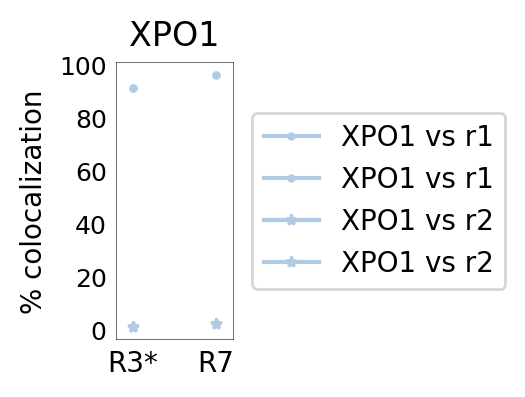

In [82]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
thin_line_properties = {
    'linewidth': 0.2  # Set the desired linewidth here
}
colors = ['#94c9de00','#94c9de00','#94c9de00']

fig, ax = plt.subplots(figsize=(0.75, 1.8), dpi=200)

#ax.plot([1,2],[c_13, c_17], color= '#fc8d62ff', label= 'XPO1 vs r1')
ax.plot([1,1],[c_13, c_13], color= '#b2cbe5', label= 'XPO1 vs r1', marker = 'o', markersize=2)
ax.plot([2,2],[c_17, c_17], color= '#b2cbe5', label= 'XPO1 vs r1', marker = 'o', markersize=2)

#ax.plot([1,2],[c_23, c_27], color= '#fc8d62ff', label= 'XPO1 vs r2', linestyle = ':')
ax.plot([1,1],[c_23, c_23], color= '#b2cbe5', label= 'XPO1 vs r2', marker = '*', markersize=4)
ax.plot([2,2],[c_27, c_27], color= '#b2cbe5', label= 'XPO1 vs r2', marker = '*', markersize=4)
 
ax.set_ylabel('% colocalization',fontsize=10)

new_tick_positions = [1, 2]
ax.set_xticks(new_tick_positions)
new_labels = ['R3*','R7']
ax.set_xlim([0.8, 2.2])
ax.set_xticklabels(new_labels, fontsize=10);
ax.tick_params(axis='y', labelsize=9,  length=0.0)
ax.set_yticks([0, 20, 40,60, 80, 100])
ax.set_title('XPO1');
ax.tick_params(axis='x', length=0.0)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(0.2)


ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));


fig.savefig('percent_coloc_xpo1_V4.svg')

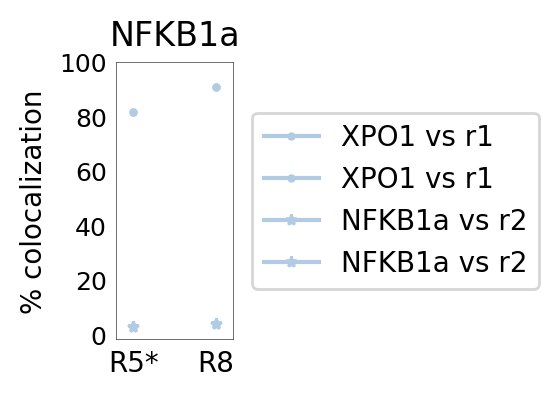

In [83]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
thin_line_properties = {
    'linewidth': 0.2  # Set the desired linewidth here
}
colors = ['#94c9de00','#94c9de00','#94c9de00']

fig, ax = plt.subplots(figsize=(0.75, 1.8), dpi=200)
 
#ax.plot([1,2],[c_25, c_28], color= '#94c9de', label= 'NFKB vs r2')

ax.plot([1,1],[c_25, c_25], color= '#b2cbe5', label= 'XPO1 vs r1', marker = 'o', markersize=2)
ax.plot([2,2],[c_28, c_28], color= '#b2cbe5', label= 'XPO1 vs r1', marker = 'o', markersize=2)

#ax.plot([1,2],[c_15, c_18], color= '#94c9de', label= 'NFKB vs r1', linestyle = ':')

ax.plot([1,1],[c_15, c_15], color= '#b2cbe5', label= 'NFKB1a vs r2', marker = '*', markersize=4)
ax.plot([2,2],[c_18, c_18], color= '#b2cbe5', label= 'NFKB1a vs r2', marker = '*', markersize=4)

ax.set_ylabel('% colocalization',fontsize=10)

new_tick_positions = [1, 2]
ax.set_xticks(new_tick_positions)
new_labels = ['R5*','R8']
ax.set_yticks([0, 20, 40,60, 80, 100])
ax.set_xlim([0.8, 2.2])
ax.set_xticklabels(new_labels, fontsize=10);
ax.tick_params(axis='y', labelsize=9,  length=0.0)
ax.set_title('NFKB1a');
ax.tick_params(axis='x', length=0.0)

for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(0.2)


ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));


fig.savefig('percent_coloc_nfkb1a_V4.svg')